# Symbolic and Semantic Scene Embeddings (with Fine-Tuning)

This notebook explores various methods for embedding symbolic scene graphs, which are represented as collections of `[subject, relation, object]` triplets. It performs a comprehensive comparison of:

1.  **Classical Symbolic Methods:** `bag`, `sequence`, and `graph` embeddings based on discrete token vocabularies.
2.  **Pre-trained Semantic Model:** A BERT-based `sentence-transformer` model (`all-MiniLM-L6-v2`) used out-of-the-box.
3.  **Fine-tuned Semantic Model:** The same BERT model, further trained on our specific scene data using contrastive learning to better differentiate between similar scenes.

The analysis evaluates each method on dimensionality, embedding space structure, and robustness to data removal. All generated plots are saved to a `plots/` directory.

## 1. Imports and Setup

This first code cell installs all necessary libraries and creates the directories for our data and plots.

In [ ]:
# This command installs the required Python packages. The '-q' flag makes the installation quiet.
# ADDED 'accelerate' to this line to fix the ImportError.
!pip install sentence-transformers datasets accelerate tqdm pandas numpy scikit-learn seaborn matplotlib torch -q

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from scipy.spatial.distance import cosine
from datasets import Dataset

# --- Create directories to save plots and data ---
plots_dir = "plots"
json_dir = "layout_tokens"
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(json_dir, exist_ok=True)

# Set a consistent and professional style for all plots generated by Seaborn.
sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)

## 2. Data Loading and Initial Analysis

We load the scene data from JSON files located in the `output_pairs` directory. Each file contains a list of tokens, from which we extract the `[subject, relation, object]` triplets. We then analyze the distribution of triplet counts across all scenes to understand the data's general structure.

Total scenes loaded: 1372
Min triplets per scene: 6
Max triplets per scene: 13060
Mean triplets per scene: 395.01
Median triplets per scene: 294.00


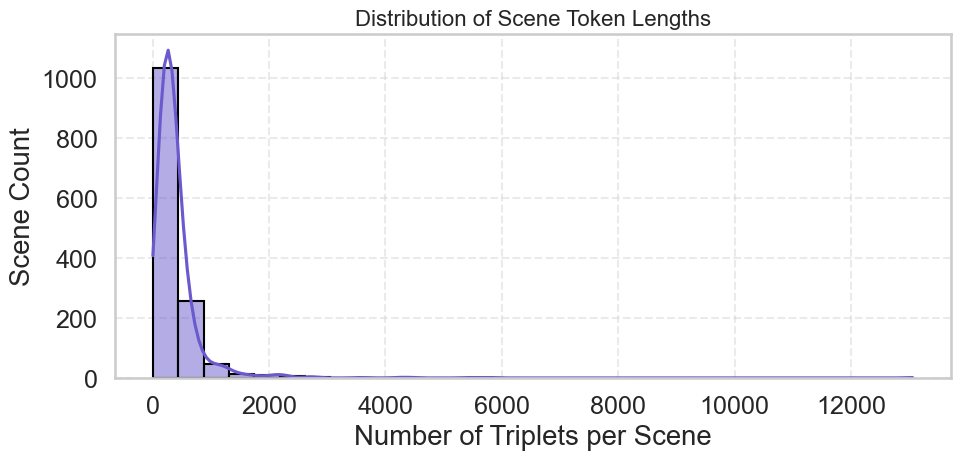

In [2]:
# List all JSON files in the specified directory.
json_files = [f for f in os.listdir(json_dir) if f.endswith(".json")]

# For reproducibility, if the directory is empty, we create a dummy file to ensure the notebook can run.
if not json_files:
    print(f"Directory '{json_dir}' is empty. Creating a dummy file for demonstration.")
    with open(os.path.join(json_dir, "dummy_scene.json"), "w") as f:
        json.dump([["cat", "on", "mat"]], f)
    json_files = ["dummy_scene.json"]

# Parse all triplets from the JSON files into a dictionary mapping filenames to triplets.
scene_triplet_map = {}
all_triplets = []

for fname in json_files:
    try:
        with open(os.path.join(json_dir, fname), "r") as f:
            tokens = json.load(f)
        triplets = [t for t in tokens if isinstance(t, list) and len(t) == 3]
        if triplets:
            scene_triplet_map[fname] = triplets
            all_triplets.extend(triplets)
    except (json.JSONDecodeError, FileNotFoundError):
        print(f"Skipping invalid or missing file: {fname}")
        continue

# --- Analyze and visualize the distribution of triplet counts per scene ---
scene_lengths = {fname: len(triplets) for fname, triplets in scene_triplet_map.items()}
lengths = list(scene_lengths.values())

print(f"Total scenes loaded: {len(lengths)}")
if lengths:
    print(f"Min triplets per scene: {min(lengths)}")
    print(f"Max triplets per scene: {max(lengths)}")
    print(f"Mean triplets per scene: {np.mean(lengths):.2f}")
    print(f"Median triplets per scene: {np.median(lengths):.2f}")

    # Plot the distribution as a histogram.
    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=30, kde=True, color='slateblue', edgecolor='black')
    plt.title("Distribution of Scene Token Lengths", fontsize=16)
    plt.xlabel("Number of Triplets per Scene")
    plt.ylabel("Scene Count")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "token_length_distribution.png"))
    plt.show()

## 3. Embedding Model Definitions

Here we define the classes for our two types of embedders:
1.  **`TokenEmbedder`**: Handles the classical, symbolic methods.
2.  **`SentenceTransformerEmbedder`**: Handles the modern, semantic methods (both pre-trained and fine-tuned).

In [3]:
class TokenEmbedder:
    """Creates symbolic embeddings from triplets based on discrete vocabularies."""
    def __init__(self, method='bag', embedding_dim=64):
        self.method = method
        self.embedding_dim = embedding_dim
        self.object_vocab = {}
        self.relation_vocab = {}
        self.next_obj_id = 0
        self.next_rel_id = 0
        self.object_embeddings = None
        self.relation_embeddings = None

    def _get_or_add(self, token, vocab, next_id):
        # Helper to add a token to a vocabulary if it's not already present.
        if token not in vocab:
            vocab[token] = next_id
            return next_id, next_id + 1
        return vocab[token], next_id

    def _initialize_embeddings(self):
        # Creates random embedding vectors for each unique object and relation.
        obj_count = len(self.object_vocab)
        rel_count = len(self.relation_vocab)
        self.object_embeddings = np.random.randn(obj_count, self.embedding_dim)
        self.relation_embeddings = np.random.randn(rel_count, self.embedding_dim)

    def fit_vocab(self, triplets):
        """Builds the object and relation vocabularies from all triplets in the dataset."""
        for obj, rel, subj in triplets:
            self.next_obj_id = self._get_or_add(obj, self.object_vocab, self.next_obj_id)[1]
            self.next_obj_id = self._get_or_add(subj, self.object_vocab, self.next_obj_id)[1]
            self.next_rel_id = self._get_or_add(rel, self.relation_vocab, self.next_rel_id)[1]
        self._initialize_embeddings()

    def _embed_triplet_bag(self, triplet):
        # For the 'bag' method, concatenates the embeddings of the subject, relation, and object.
        obj, rel, subj = triplet
        v_obj = self.object_embeddings[self.object_vocab[obj]]
        v_rel = self.relation_embeddings[self.relation_vocab[rel]]
        v_subj = self.object_embeddings[self.object_vocab[subj]]
        return np.concatenate([v_obj, v_rel, v_subj])

    def _valid_triplet(self, triplet):
        # Checks if all elements of a triplet are in the learned vocabulary.
        obj, rel, subj = triplet
        return obj in self.object_vocab and subj in self.object_vocab and rel in self.relation_vocab

    def embed_scene(self, triplets):
        """Embeds a single scene by averaging the embeddings of its constituent triplets."""
        if self.method == 'bag':
            valid_vecs = [self._embed_triplet_bag(t) for t in triplets if self._valid_triplet(t)]
            return np.mean(valid_vecs, axis=0) if valid_vecs else np.zeros(self.embedding_dim * 3)
        elif self.method == 'sequence' or self.method == 'graph': # Graph and sequence are treated similarly here
            vecs = []
            for obj, rel, subj in triplets:
                if self._valid_triplet((obj, rel, subj)):
                    vecs.append(self.object_embeddings[self.object_vocab[obj]])
                    vecs.append(self.relation_embeddings[self.relation_vocab[rel]])
                    vecs.append(self.object_embeddings[self.object_vocab[subj]])
            return np.mean(vecs, axis=0) if vecs else np.zeros(self.embedding_dim)
        else:
            raise ValueError(f"Unknown method: {self.method}")

class SentenceTransformerEmbedder:
    """Creates semantic embeddings using a pre-trained Sentence Transformer model."""
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)
        self.embedding_dim = self.model.get_sentence_embedding_dimension()
        
    def _triplets_to_text(self, triplets):
        """Converts a list of triplets into a single paragraph of text."""
        sentences = [f"{subj.replace('_', ' ')} {rel.replace('_', ' ')} {obj.replace('_', ' ')}." for subj, rel, obj in triplets]
        return " ".join(sentences)

    def embed_scene(self, triplets):
        """Embeds a scene by converting its triplets to text and then encoding it."""
        if not triplets:
            return np.zeros(self.embedding_dim)
        text = self._triplets_to_text(triplets)
        return self.model.encode(text)

## 4. Fine-Tuning the Semantic Model

To create an embedding space that is better at distinguishing between our specific scenes, we fine-tune the pre-trained BERT model. We use **contrastive learning** with a **TripletLoss** function. This requires creating training examples of `(anchor, positive, negative)` scenes:
- **Anchor**: A base scene.
- **Positive**: A very similar scene (the anchor with one triplet removed).
- **Negative**: A dissimilar scene (a randomly chosen different scene).

The model learns to pull the anchor and positive embeddings closer together while pushing the anchor and negative embeddings further apart.

In [4]:
def create_triplet_examples(scene_map, num_examples=2000):
    """Generates (anchor, positive, negative) training examples for TripletLoss."""
    train_examples = []
    scene_names = list(scene_map.keys())

    if len(scene_names) < 2:
        print("Not enough scenes to create training examples.")
        return []

    print(f"Generating {num_examples} training examples for fine-tuning...")
    for _ in tqdm(range(num_examples)):
        # 1. Select an anchor scene
        anchor_name = random.choice(scene_names)
        anchor_triplets = scene_map[anchor_name]

        if len(anchor_triplets) < 2:
            continue  # Ensure we can remove a triplet to create a positive example

        # 2. Create a positive example by removing one triplet
        positive_triplets = random.sample(anchor_triplets, len(anchor_triplets) - 1)

        # 3. Select a different, negative scene
        negative_name = random.choice(scene_names)
        while negative_name == anchor_name:
            negative_name = random.choice(scene_names)
        negative_triplets = scene_map[negative_name]

        # 4. Convert to text and create the InputExample object
        anchor_text = SentenceTransformerEmbedder._triplets_to_text(None, anchor_triplets)
        positive_text = SentenceTransformerEmbedder._triplets_to_text(None, positive_triplets)
        negative_text = SentenceTransformerEmbedder._triplets_to_text(None, negative_triplets)

        train_examples.append(InputExample(texts=[anchor_text, positive_text, negative_text]))

    return train_examples

# --- 1. Data Preparation ---
# Note: For a real-world task, you might use a much larger number of examples.
train_examples = create_triplet_examples(scene_triplet_map, num_examples=2000)
print(f"\nCreated {len(train_examples)} examples.")

# --- 2. Model Fine-Tuning ---
if train_examples:
    # Define the path where the fine-tuned model will be saved/loaded from
    finetuned_model_path = './fine_tuned_bert'

    # Check if a model checkpoint already exists at the specified path
    if os.path.exists(finetuned_model_path):
        # If it exists, load the model directly and skip training
        print(f"\nFound existing fine-tuned model. Loading from: {finetuned_model_path}")
        model = SentenceTransformer(finetuned_model_path)
    
    else:
        # If no checkpoint is found, proceed with the original training process
        print(f"\nNo fine-tuned model found. Starting new training process.")
        model_name = 'all-MiniLM-L6-v2'
        print(f"\nLoading pre-trained model: {model_name}")
        model = SentenceTransformer(model_name)

        # Define the loss function and data loader
        train_loss = losses.TripletLoss(model=model)
        train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

        print("Starting fine-tuning process (this may take a few minutes)...")
        # For this demonstration, we only train for 1 epoch. Increase this for better results.
        # The model.fit() function will automatically save the trained model to the `output_path`.
        model.fit(train_objectives=[(train_dataloader, train_loss)],
                  epochs=1,
                  warmup_steps=100,
                  output_path=finetuned_model_path)
        print(f"Fine-tuned model saved to: {finetuned_model_path}")
else:
    print("\nSkipping fine-tuning due to lack of training data.")

Generating 2000 training examples for fine-tuning...


  0%|          | 0/2000 [00:00<?, ?it/s]


Created 2000 examples.

Found existing fine-tuned model. Loading from: ./fine_tuned_bert


## 5. Generating and Analyzing All Embeddings

Now we add our new fine-tuned model to the list of configurations and run the full analysis pipeline again to compare all five methods.

In [5]:
embedding_configs = [
    {'name': 'symbolic_bag', 'type': 'symbolic', 'params': {'method': 'bag', 'embedding_dim': 64}},
    {'name': 'symbolic_sequence', 'type': 'symbolic', 'params': {'method': 'sequence', 'embedding_dim': 64}},
    {'name': 'symbolic_graph', 'type': 'symbolic', 'params': {'method': 'graph', 'embedding_dim': 64}},
    {'name': 'bert_pretrained', 'type': 'semantic', 'params': {'model_name': 'all-MiniLM-L6-v2'}},
    # Add the fine-tuned model by pointing to its local path
    {'name': 'bert_finetuned', 'type': 'semantic', 'params': {'model_name': './fine_tuned_bert'}}
]

df_all_proj = []
df_all_var = []

for config in embedding_configs:
    method_name = config['name']
    print(f"\n=== Processing method: {method_name.upper()} ===")

    try:
        if config['type'] == 'symbolic':
            embedder = TokenEmbedder(**config['params'])
            embedder.fit_vocab(all_triplets)
        elif config['type'] == 'semantic':
            embedder = SentenceTransformerEmbedder(**config['params'])
    except Exception as e:
        print(f"[ERROR] Could not load model for '{method_name}'. It might not have been trained. Skipping. Error: {e}")
        continue

    scene_embeddings, scene_labels = [], []
    for fname, triplets in scene_triplet_map.items():
        vec = embedder.embed_scene(triplets)
        if vec is not None and isinstance(vec, np.ndarray) and not np.isnan(vec).any() and not np.all(vec == 0):
            scene_embeddings.append(vec)
            scene_labels.append(os.path.splitext(fname)[0])

    if not scene_embeddings:
        print(f"[WARNING] No valid embeddings for method '{method_name}'.")
        continue

    scene_embeddings = np.stack(scene_embeddings)
    print(f"[OK] {len(scene_embeddings)} scenes processed. Shape: {scene_embeddings.shape}")

    # --- PCA Analysis ---
    pca = PCA()
    scene_proj = pca.fit_transform(scene_embeddings)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    cutoff_90 = np.argmax(cumulative_variance >= 0.9) + 1

    df_proj = pd.DataFrame(scene_proj[:, :2], columns=["PC1", "PC2"])
    df_proj["Scene"] = scene_labels
    df_proj["Method"] = method_name
    df_all_proj.append(df_proj)

    df_var = pd.DataFrame({
        "Component": np.arange(1, len(explained_variance) + 1),
        "Explained Variance": explained_variance,
        "Cumulative Variance": cumulative_variance,
        "Method": method_name,
        "Cutoff90": cutoff_90,
        "OriginalDim": scene_embeddings.shape[1]
    })
    df_all_var.append(df_var)

# Concatenate final results into DataFrames
if df_all_proj and df_all_var:
    df_all_proj = pd.concat(df_all_proj, ignore_index=True)
    df_all_var = pd.concat(df_all_var, ignore_index=True)
else:
    print("\nNo data processed to generate reports.")


=== Processing method: SYMBOLIC_BAG ===
[OK] 1372 scenes processed. Shape: (1372, 192)

=== Processing method: SYMBOLIC_SEQUENCE ===
[OK] 1372 scenes processed. Shape: (1372, 64)

=== Processing method: SYMBOLIC_GRAPH ===
[OK] 1372 scenes processed. Shape: (1372, 64)

=== Processing method: BERT_PRETRAINED ===


c:\Users\Hagai.LAPTOP-QAG9263N\.conda\envs\thesis\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[OK] 1372 scenes processed. Shape: (1372, 384)

=== Processing method: BERT_FINETUNED ===


c:\Users\Hagai.LAPTOP-QAG9263N\.conda\envs\thesis\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[OK] 1372 scenes processed. Shape: (1372, 384)


## 6. Final Results and Visualization

This section visualizes the results of the comparative analysis, including the newly fine-tuned model.

--- Compression Ratio Summary ---
              Method  OriginalDim  CompressedDim90  CompressionRatio
0     bert_finetuned          384                9          0.023438
1    bert_pretrained          384               37          0.096354
2       symbolic_bag          192               24          0.125000
3     symbolic_graph           64               15          0.234375
4  symbolic_sequence           64               16          0.250000


C:\Users\Hagai.LAPTOP-QAG9263N\AppData\Local\Temp\ipykernel_1036\3295608690.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x="Method", y="CompressionRatio", palette="viridis", edgecolor="black")


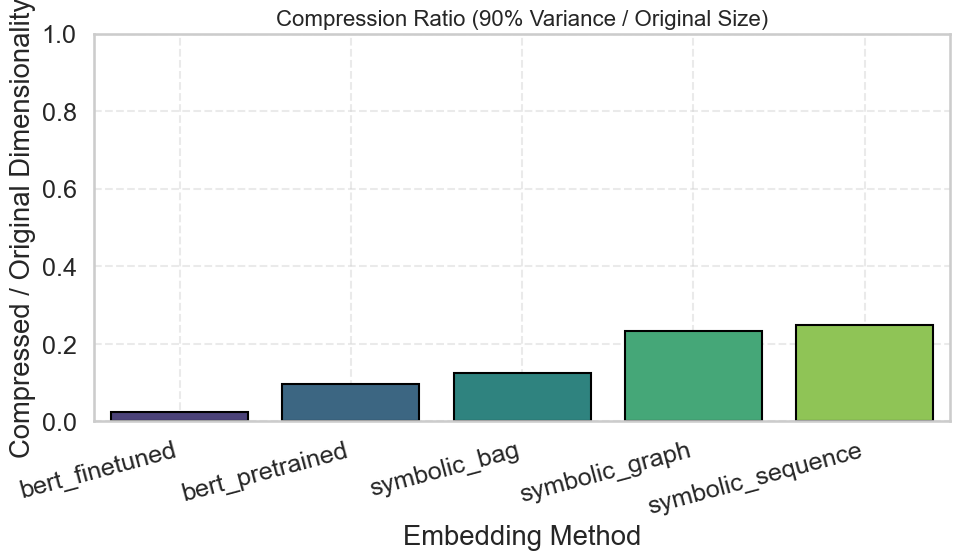

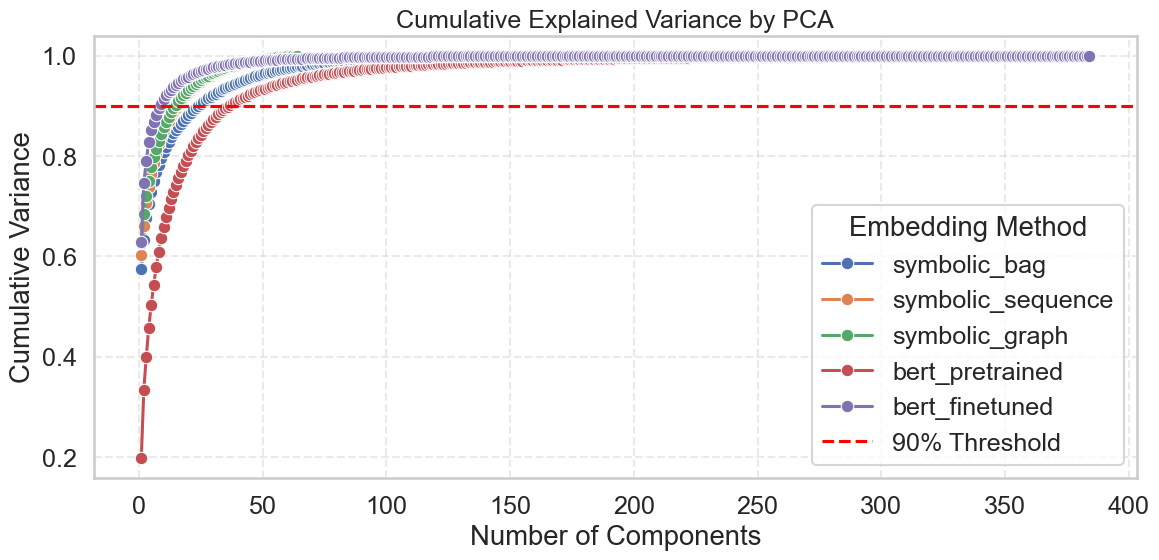

In [6]:
if not df_all_var.empty:
    # --- Compression Ratio --- 
    summary = df_all_var.groupby("Method").agg(
        OriginalDim=("OriginalDim", "first"),
        CompressedDim90=("Cutoff90", "first")
    ).reset_index()
    summary["CompressionRatio"] = summary["CompressedDim90"] / summary["OriginalDim"]
    summary.sort_values("CompressionRatio", inplace=True)
    print("--- Compression Ratio Summary ---")
    print(summary)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=summary, x="Method", y="CompressionRatio", palette="viridis", edgecolor="black")
    plt.title("Compression Ratio (90% Variance / Original Size)", fontsize=16)
    plt.ylabel("Compressed / Original Dimensionality")
    plt.xlabel("Embedding Method")
    plt.xticks(rotation=15, ha='right')
    plt.ylim(0, 1)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "compression_ratio.png"))
    plt.show()

    # --- Explained Variance Plot ---
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_all_var, x="Component", y="Cumulative Variance", hue="Method", marker="o", linewidth=2.2)
    plt.axhline(0.9, color="red", linestyle="--", label="90% Threshold")
    plt.title("Cumulative Explained Variance by PCA", fontsize=18)
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance")
    plt.legend(title="Embedding Method")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "cumulative_explained_variance.png"))
    plt.show()

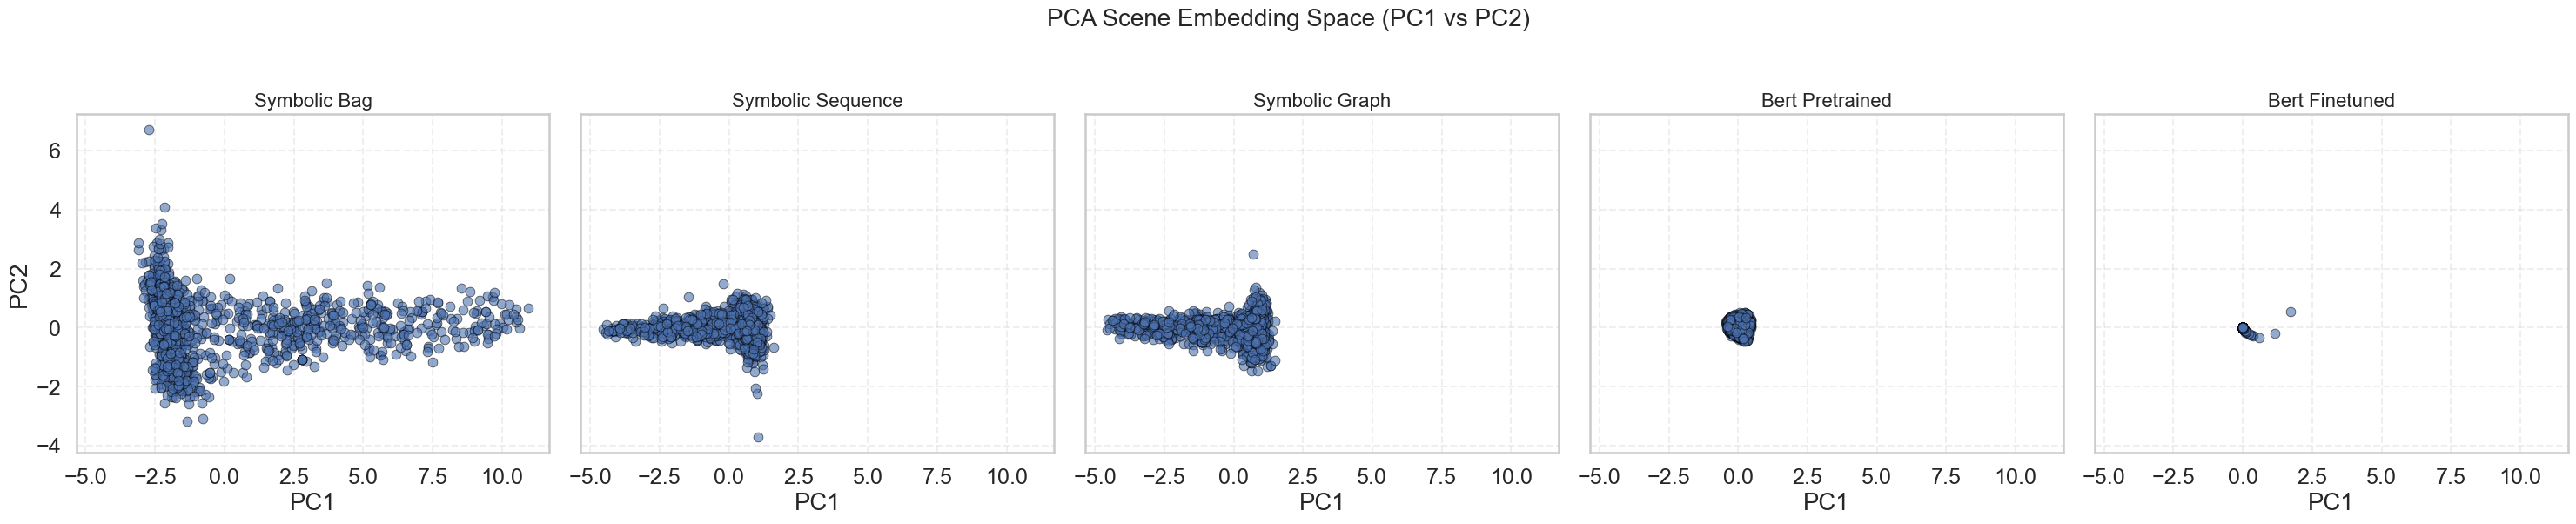

In [7]:
if not df_all_proj.empty:
    # --- PCA Embedding Space ---
    methods_list = df_all_proj['Method'].unique()
    num_methods = len(methods_list)
    fig, axes = plt.subplots(1, num_methods, figsize=(6 * num_methods, 6), sharex=True, sharey=True)
    if num_methods == 1:
        axes = [axes] # Make it iterable for a single plot
        
    for i, method in enumerate(methods_list):
        ax = axes[i]
        df = df_all_proj[df_all_proj["Method"] == method]
        sns.scatterplot(data=df, x="PC1", y="PC2", ax=ax, s=60, edgecolor="black", alpha=0.6)
        ax.set_title(f"{method.replace('_', ' ').title()}", fontsize=16)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2" if i == 0 else "")
        ax.grid(True, linestyle="--", alpha=0.3)

    fig.suptitle("PCA Scene Embedding Space (PC1 vs PC2)", fontsize=20, y=1.02)
    plt.tight_layout()
    fig.savefig(os.path.join(plots_dir, "pca_embedding_space.png"))
    plt.show()

## 7. Robustness Evaluation (Including Fine-Tuned Model)

Finally, we repeat the robustness evaluation to see if fine-tuning improved the model's stability and semantic sensitivity.


Evaluating robustness: symbolic_bag


Method: symbolic_bag:   0%|          | 0/400 [00:00<?, ?it/s]


Evaluating robustness: symbolic_sequence


Method: symbolic_sequence:   0%|          | 0/400 [00:00<?, ?it/s]


Evaluating robustness: symbolic_graph


Method: symbolic_graph:   0%|          | 0/400 [00:00<?, ?it/s]


Evaluating robustness: bert_pretrained


Method: bert_pretrained:   0%|          | 0/400 [00:00<?, ?it/s]

c:\Users\Hagai.LAPTOP-QAG9263N\.conda\envs\thesis\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Evaluating robustness: bert_finetuned


Method: bert_finetuned:   0%|          | 0/400 [00:00<?, ?it/s]

C:\Users\Hagai.LAPTOP-QAG9263N\AppData\Local\Temp\ipykernel_1036\2001215692.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_robust, x="FractionRemoved", y="L2_Diff", hue="Method", ci="sd", marker="o", ax=axes[0])
C:\Users\Hagai.LAPTOP-QAG9263N\AppData\Local\Temp\ipykernel_1036\2001215692.py:68: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_robust, x="FractionRemoved", y="Cosine_Sim", hue="Method", ci="sd", marker="o", ax=axes[1])


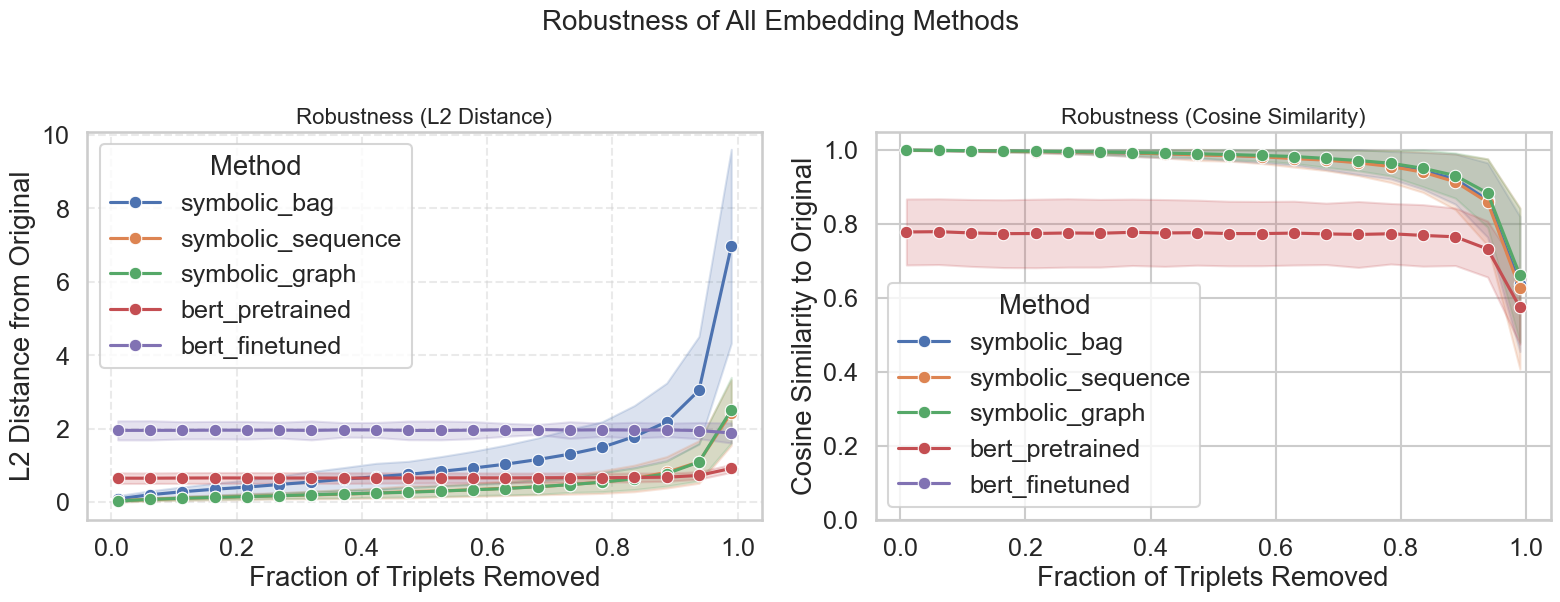

In [ ]:
# Parameters for robustness check
num_samples = 400
removal_fractions = np.linspace(0.01, 0.99, num=20)
robustness_results = []

def compute_embedding_difference(embedder, original, modified):
    v_orig = embedder.embed_scene(original)
    v_mod = embedder.embed_scene(modified)
    
    # Check for invalid vectors (NaNs or all zeros)
    if np.any(np.isnan(v_orig)) or np.all(v_orig == 0) or np.any(np.isnan(v_mod)) or np.all(v_mod == 0):
        return None, None

    l2_diff = np.linalg.norm(v_orig - v_mod)
    cos_sim = 1 - cosine(v_orig, v_mod)
    return l2_diff, cos_sim

# Run for each method
for config in embedding_configs:
    method_name = config['name']
    print(f"\nEvaluating robustness: {method_name}")
    
    try:
        if config['type'] == 'symbolic':
            embedder = TokenEmbedder(**config['params'])
            embedder.fit_vocab(all_triplets)
        elif config['type'] == 'semantic':
            embedder = SentenceTransformerEmbedder(**config['params'])
    except Exception as e:
        print(f"[ERROR] Could not load model for '{method_name}'. Skipping. Error: {e}")
        continue

    for _ in tqdm(range(num_samples), desc=f"Method: {method_name}"):
        scene_name = random.choice(list(scene_triplet_map.keys()))
        original_triplets = scene_triplet_map[scene_name]

        if len(original_triplets) < 4:
            continue

        for frac in removal_fractions:
            k = max(1, int(len(original_triplets) * frac))
            if k >= len(original_triplets):
                continue
                
            kept_triplets = random.sample(original_triplets, len(original_triplets) - k)

            l2, cos = compute_embedding_difference(embedder, original_triplets, kept_triplets)
            if l2 is not None:
                robustness_results.append({
                    "Method": method_name,
                    "FractionRemoved": frac,
                    "L2_Diff": l2,
                    "Cosine_Sim": cos
                })


C:\Users\Hagai.LAPTOP-QAG9263N\AppData\Local\Temp\ipykernel_1036\2914492093.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_robust, x="FractionRemoved", y="L2_Diff", hue="Method", ci="sd", marker="o", ax=axes[0])
C:\Users\Hagai.LAPTOP-QAG9263N\AppData\Local\Temp\ipykernel_1036\2914492093.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_robust, x="FractionRemoved", y="Cosine_Sim", hue="Method", ci="sd", marker="o", ax=axes[1])


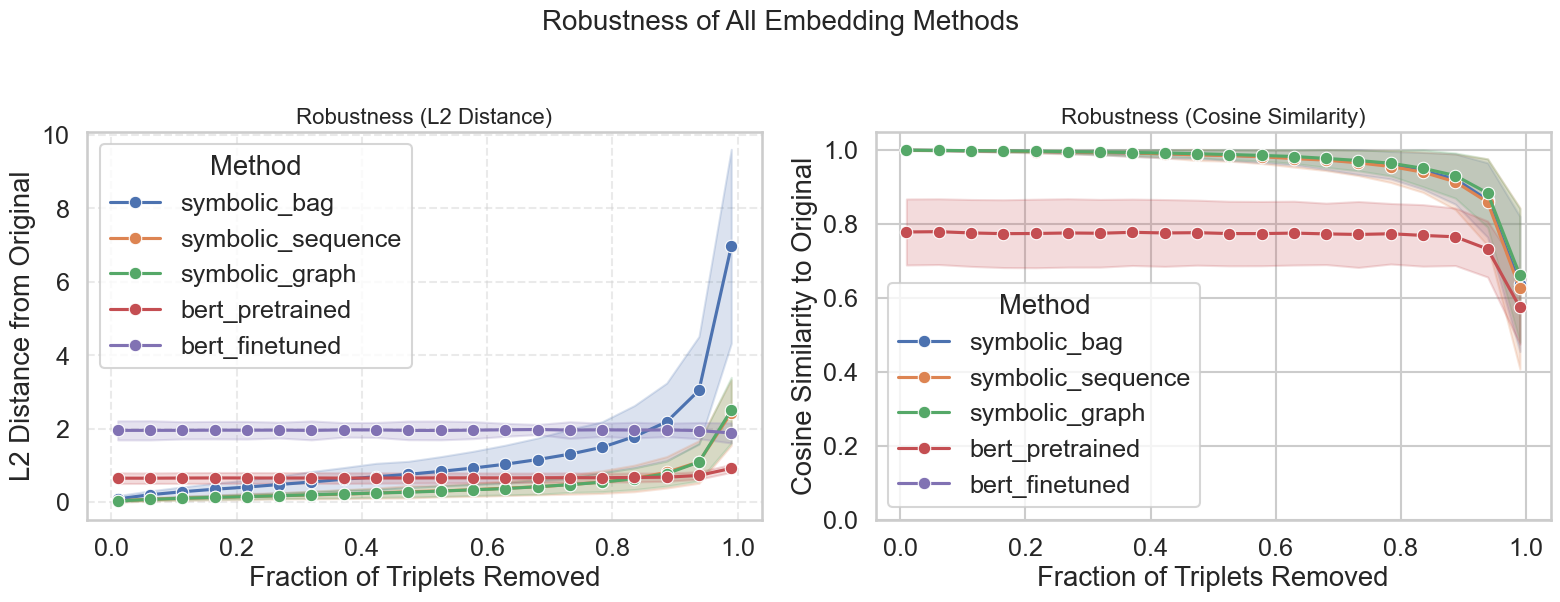

In [9]:

if robustness_results:
    df_robust = pd.DataFrame(robustness_results)
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.lineplot(data=df_robust, x="FractionRemoved", y="L2_Diff", hue="Method", ci="sd", marker="o", ax=axes[0])
    axes[0].set_title("Robustness (L2 Distance)", fontsize=16)
    axes[0].set_xlabel("Fraction of Triplets Removed")
    axes[0].set_ylabel("L2 Distance from Original")
    axes[0].grid(True, linestyle="--", alpha=0.4)
    axes[0].legend(title="Method")

    sns.lineplot(data=df_robust, x="FractionRemoved", y="Cosine_Sim", hue="Method", ci="sd", marker="o", ax=axes[1])
    axes[1].set_title("Robustness (Cosine Similarity)", fontsize=16)
    axes[1].set_xlabel("Fraction of Triplets Removed")
    axes[1].set_ylabel("Cosine Similarity to Original")
    axes[1].legend(title="Method")
    axes[1].set_ylim(0, 1.05)

    fig.suptitle("Robustness of All Embedding Methods", fontsize=20, y=1.02)
    plt.tight_layout()
    fig.savefig(os.path.join(plots_dir, "robustness_evaluation.png"))
    plt.show()
else:
    print("\nNo robustness data generated.")